In [150]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Wave and spectrogram

In [151]:
train_audio_path = '../data/input/train/audio/'
#filename = '/yes/0a7c2a8d_nohash_0.wav'
filename = '/_background_noise_/doing_the_dishes.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [152]:
samples.dtype, len(samples)

(dtype('int16'), 16000)

In [153]:
print('min in samples : {0}, max in samples : {1}'.format(min(samples), max(samples)))

min in samples : -6445, max in samples : 9411


In [154]:
sample_rate

16000

In [155]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    # print('nperseg:{0}'.format(nperseg))
    noverlap = int(round(step_size * sample_rate / 1e3))
    # print('noverlap:{0}'.format(noverlap))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [156]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
# nperseg : 每个segment的采样个数
# noverlap : 不同segment的重叠的个数
# 每个segment有320个采样值，两个segment之间重叠50%，即160个采样

In [157]:
# freqs, times, spectrogram, len(spectrogram)

In [158]:
freqs.shape, times.shape, spectrogram.shape

((161,), (99,), (99, 161))

x shape : (16000,)
y shape : (16000,)
freqs min value : 0.0, freqs max value 8000.0


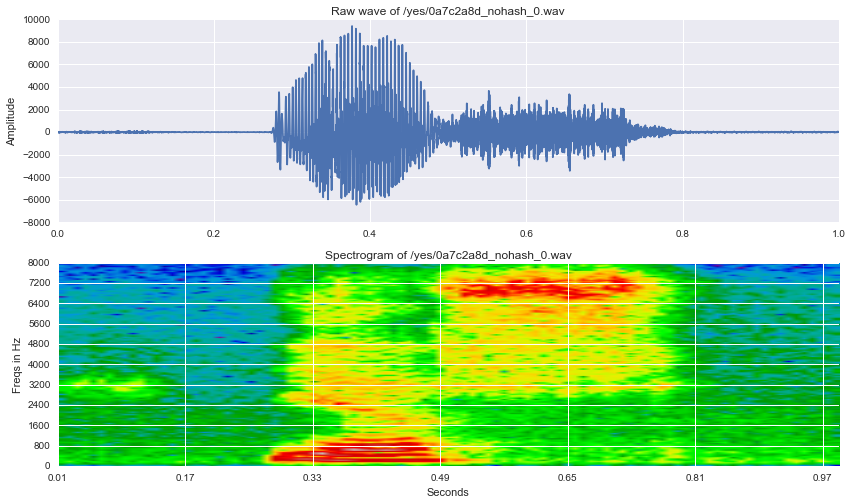

In [159]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
_x = np.linspace(0, len(samples)/sample_rate, len(samples))
_y = samples
print('x shape : {0}'.format(_x.shape))
print('y shape : {0}'.format(_y.shape))
ax1.plot(_x, _y)
print('freqs min value : {0}, freqs max value {1}'.format(min(freqs), max(freqs)))
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='nipy_spectral', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [160]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std
# mean, std, spectrogram

# Mel spectrogram and MFCC

## Mel spectrogram

In [161]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
# n_mels有多少个 就有多少个数据
log_S = librosa.power_to_db(S, ref=np.max)
print('length of log_S : {0}'.format(len(log_S)))

length of log_S : 128


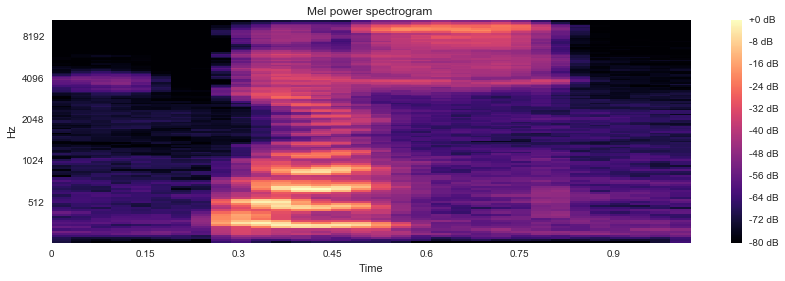

In [162]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## MFCC

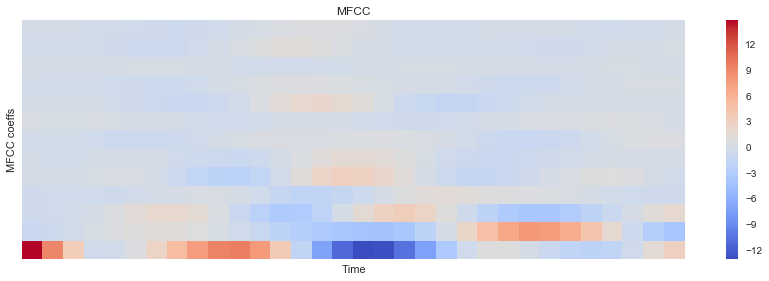

In [163]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# Silence removal

In [164]:
ipd.Audio(samples, rate=sample_rate)

# Dataset investigation

In [165]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [166]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridius', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

In [167]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

Number of recordings shorter than 1 second: 6469


In [168]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


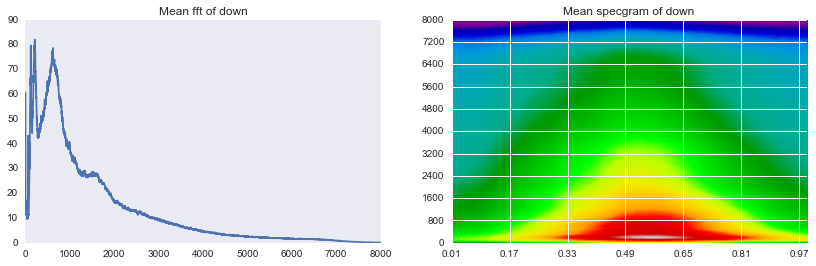

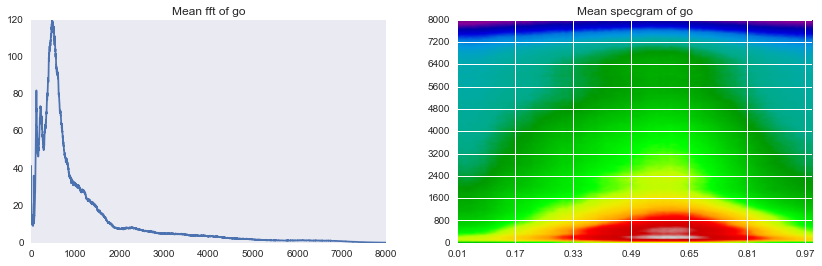

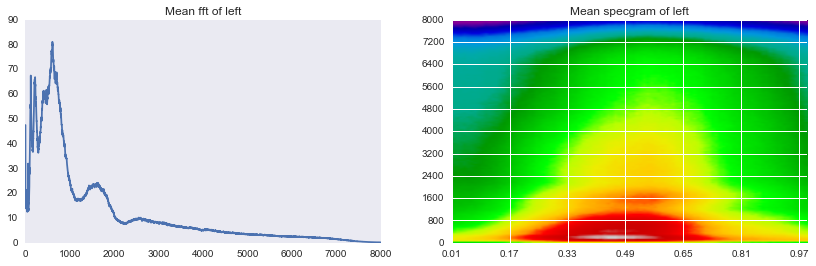

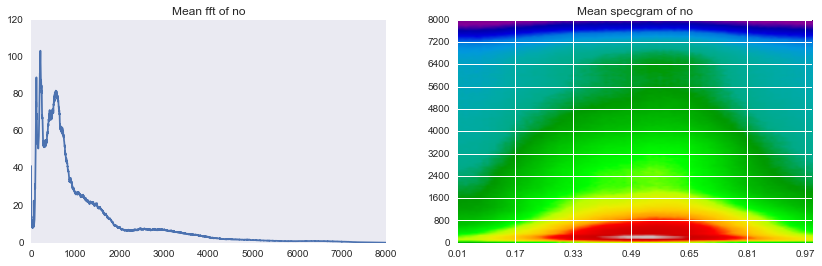

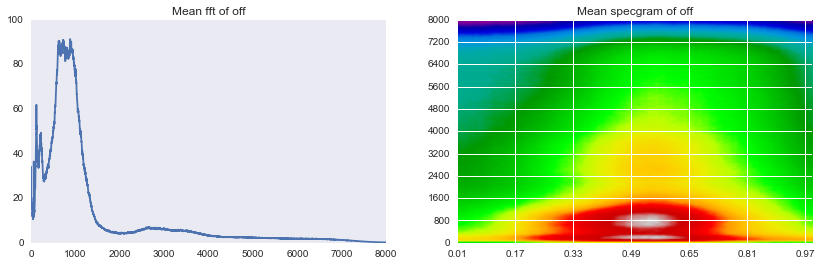

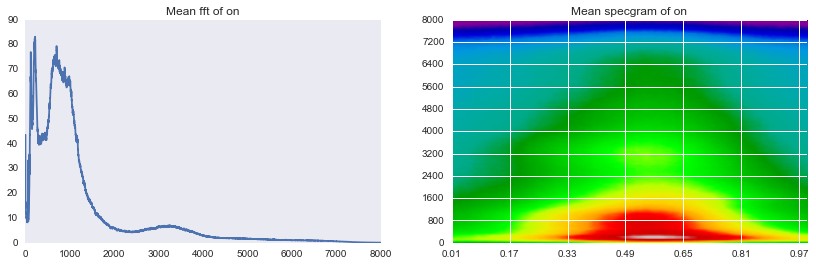

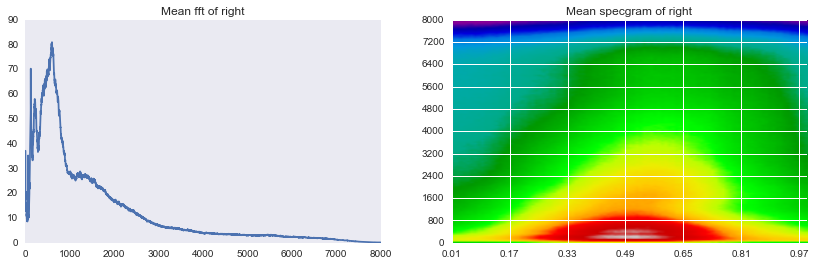

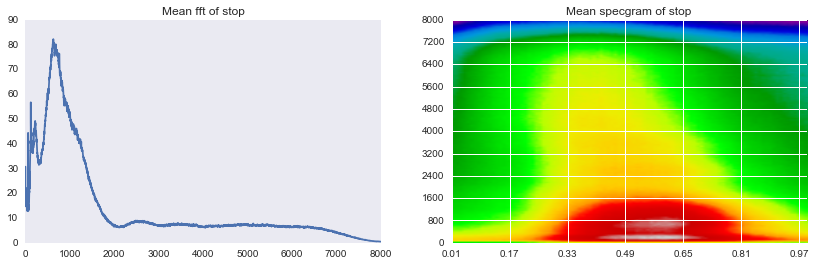

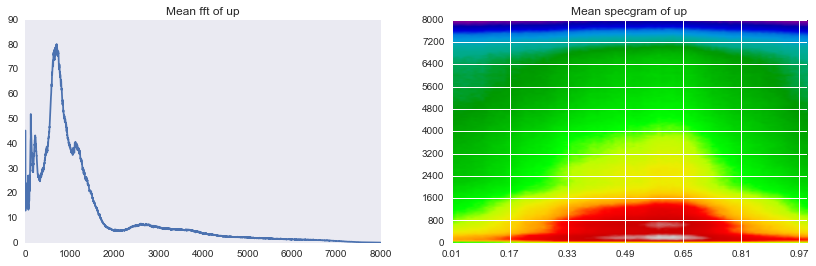

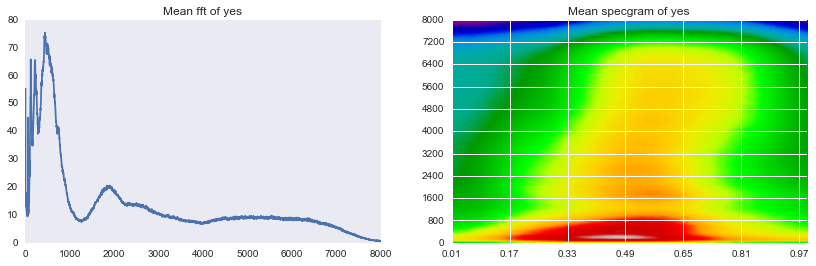

In [170]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', cmap='nipy_spectral', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

# Frequency components across the words

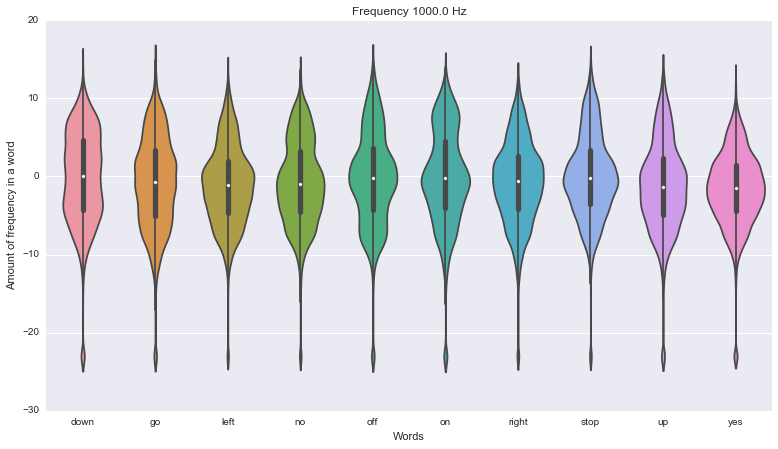

In [171]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

violinplot_frequency(dirs, 20)